In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import misc
from numpy import linalg as LA
from dnn import NeuralNet

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from utils import avgn_attack


import itertools
import collections

from sklearn import datasets

from numba import jit

%matplotlib inline

In [2]:
filename_test = "./data/digit-recognizer/test.csv"
filename_train = "./data/digit-recognizer/train.csv"

df_train = pd.read_csv(filename_train, delimiter=',')
df_test = pd.read_csv(filename_test, delimiter=',')

X = df_train.loc[:, df_train.columns != "label"]
y = df_train.loc[:, df_train.columns == "label"]
X = X.to_numpy()
y = y.to_numpy()
print('Dataset: X={}, y={}'.format(X.shape, y.shape))

Dataset: X=(42000, 784), y=(42000, 1)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, stratify = y)

print('Training set: X={}, y={}'.format(X_train.shape, y_train.shape))
print('Test set: X={}, y={}'.format(X_test.shape, y_test.shape))

Training set: X=(33600, 784), y=(33600, 1)
Test set: X=(8400, 784), y=(8400, 1)


In [13]:
# Layers used in this model
class Layer(object):
    """Base class for the different layers.
    Defines base methods and documentation of methods."""
    
    def get_params_iter(self):
        """Return an iterator over the parameters (if any).
        The iterator has the same order as get_params_grad.
        The elements returned by the iterator are editable in-place."""
        return []
    
    def get_params_grad(self, X, output_grad):
        """Return a list of gradients over the parameters.
        The list has the same order as the get_params_iter iterator.
        X is the input.
        output_grad is the gradient at the output of this layer.
        """
        return []
    
    def get_output(self, X):
        """Perform the forward step linear transformation.
        X is the input."""
        pass
    
    def get_input_grad(self, Y, output_grad=None, T=None):
        """Return the gradient at the inputs of this layer.
        Y is the pre-computed output of this layer (not needed in 
        this case).
        output_grad is the gradient at the output of this layer 
         (gradient at input of next layer).
        Output layer uses targets T to compute the gradient based on the 
         output error instead of output_grad"""
        pass

In [14]:
class SoftmaxOutputLayer(Layer):
    """The softmax output layer computes the classification 
    propabilities at the output."""
    
    def get_output(self, X):
        """Perform the forward step transformation."""
        return softmax(X)
    
    def get_input_grad(self, Y, T):
        """Return the gradient at the inputs of this layer."""
        return (Y - T) / Y.shape[0]
    
    def get_cost(self, Y, T):
        """Return the cost at the output of this output layer."""
        return 1/2 * np.sum((Y - T)**2)

In [15]:
class LinearLayer(Layer):
    """The linear layer performs a linear transformation to its input."""
    
    def __init__(self, n_in, n_out):
        """Initialize hidden layer parameters.
        n_in is the number of input variables.
        n_out is the number of output variables."""
        self.W = np.random.randn(n_in, n_out) * 0.1
        self.b = np.zeros(n_out)
        
    def get_params_iter(self):
        """Return an iterator over the parameters."""
        return itertools.chain(
            np.nditer(self.W, op_flags=['readwrite']),
            np.nditer(self.b, op_flags=['readwrite']))
    
    def get_output(self, X):
        """Perform the forward step linear transformation."""
        return (X @ self.W) + self.b
        
    def get_params_grad(self, X, output_grad):
        """Return a list of gradients over the parameters."""
        # output_grad = dZ
        # X.T = Activation (A)
        JW = X.T @ output_grad
        Jb = np.sum(output_grad, axis=0)
        return [g for g in itertools.chain(
            np.nditer(JW), np.nditer(Jb))]
    
    def get_input_grad(self, Y, output_grad):
        """Return the gradient at the inputs of this layer."""
        return output_grad @ self.W.T

In [16]:
class TanhLayer(Layer, activation):
    def get_output(self, X):
        """Perform the forward step transformation."""
        return tanh(X)
    
    def get_input_grad(self, Y, output_grad):
        """Return the gradient at the inputs of this layer."""
        return np.multiply(logistic_deriv(Y), output_grad)

class SigmoidLayer(Layer, activation):
    def get_output(self, X):
        """Perform the forward step transformation."""
        return sigmoid(X)
    
    def get_input_grad(self, Y, output_grad):
        """Return the gradient at the inputs of this layer."""
        return np.multiply(logistic_deriv(Y), output_grad)

class ReluLayer(Layer, activation):
    def get_output(self, X):
        """Perform the forward step transformation."""
        pass
    
    def get_input_grad(self, Y, output_grad):
        """Return the gradient at the inputs of this layer."""
        return np.multiply(tanh_deriv(Y), output_grad)

In [17]:
class MSE(Layer):
    """The softmax output layer computes the classification 
    propabilities at the output."""
    
    def get_output(self, X):
        """Perform the forward step transformation."""
        return X
    
    def get_input_grad(self, Y, T):
        """Return the gradient at the inputs of this layer."""
        return (Y - T) / Y.shape[0]
    
    def get_cost(self, Y, T):
        """Return the cost at the output of this output layer."""
        return np.mean((Y - T) ** 2)
#         return 1/2 * np.mean(Y - T, axis=1)**2

In [18]:
# Forward propagation step as a method.
def forward_step(input_samples, layers):
    """
    Compute and return the forward activation of each layer in layers.
    Input:
        input_samples: A matrix of input samples (each row 
                       is an input vector)
        layers: A list of Layers
    Output:
        A list of activations where the activation at each index 
        i+1 corresponds to the activation of layer i in layers. 
        activations[0] contains the input samples.  
    """
    activations = [input_samples] # List of layer activations
    # Compute the forward activations for each layer starting 
    #  from the first
    X = input_samples
    for layer in layers:
        # Get the output of the current layer
        Y = layer.get_output(X)
        # Store the output for future processing
        activations.append(Y)
        # Set the current input as the activations of the previous layer
        X = activations[-1]
    return activations

In [19]:
# Define the backward propagation step as a method
def backward_step(activations, targets, layers):
    """
    Perform the backpropagation step over all the layers and return the parameter gradients.
    Input:
        activations: A list of forward step activations where the activation at 
            each index i+1 corresponds to the activation of layer i in layers. 
            activations[0] contains the input samples. 
        targets: The output targets of the output layer.
        layers: A list of Layers corresponding that generated the outputs in activations.
    Output:
        A list of parameter gradients where the gradients at each index corresponds to
        the parameters gradients of the layer at the same index in layers. 
    """
    # List of parameter gradients for each layer
    param_grads = collections.deque()
    
    # The error gradient at the output of the current layer
    output_grad = None

    # Propagate the error backwards through all the layers.
    for layer in reversed(layers):
        # Get the activations of the last layer on the stack
        Y = activations.pop()
        # The output layer error is calculated different then hidden layer error.
        if output_grad is None:
            input_grad = layer.get_input_grad(Y, targets)
        else:  # output_grad is not None (layer is not output layer)
            input_grad = layer.get_input_grad(Y, output_grad)
        # Get the input of this layer (activations of the previous layer)
        X = activations[-1]

        # Compute the layer parameter gradients used to update the parameters
        grads = layer.get_params_grad(X, output_grad)
        param_grads.appendleft(grads)
        # Compute gradient at output of previous layer (input of current layer):
        output_grad = input_grad
    return list(param_grads)  # Return the parameter gradients

In [20]:

# # Load the data from scikit-learn.
# digits = datasets.load_digits()

# # Load the targets.
# # Note that the targets are stored as digits, these need to be 
# #  converted to one-hot-encoding for the output sofmax layer.
# T = np.zeros((digits.target.shape[0], 10))
# T[np.arange(len(T)), digits.target] += 1

# # Divide the data into a train and test set.
# (X_train, X_test, T_train, T_test
# ) = train_test_split(digits.data, T, test_size=0.4)
# # Divide the test set into a validation set and final test set.
# (X_validation, X_test, T_validation, T_test
# ) = train_test_split(X_test, T_test, test_size=0.5)

# X_train = X_train / 255
# X_test = X_test / 255

# T_test = X_test
# T_train = X_train

X_train = X_train / 255
X_test = X_test / 255

In [24]:
# Define a method to update the parameters
def update_params(layers, param_grads, learning_rate):
    """
    Function to update the parameters of the given layers with the given 
    gradients by gradient descent with the given learning rate.
    """
    for layer, layer_backprop_grads in zip(layers, param_grads):
        for param, grad in zip(layer.get_params_iter(), 
                               layer_backprop_grads):
            # The parameter returned by the iterator point to the 
            #  memory space of the original layer and can thus be 
            param -= learning_rate * grad  # Update each parameter

In [25]:
def fit()

In [ ]:
# Sample model to be trained on the data
hidden_neurons_1 = 32  # Number of neurons in the first hidden-layer
hidden_neurons_2 = 8  # Number of neurons in the second hidden-layer

# Create the model
layers = [] # Define a list of layers
# Add first hidden layer
layers.append(LinearLayer(X_train.shape[1], hidden_neurons_1))
layers.append(LogisticLayer())
# Add second hidden layer
layers.append(LinearLayer(hidden_neurons_1, hidden_neurons_2))
layers.append(LogisticLayer())
# Add output layer
layers.append(LinearLayer(hidden_neurons_2, X_train.shape[1]))
layers.append(LogisticLayer())

layers.append(LinearLayer(X_train.shape[1], hidden_neurons_2))
layers.append(LogisticLayer())

layers.append(LinearLayer(hidden_neurons_2, hidden_neurons_1))
layers.append(LogisticLayer())

layers.append(LinearLayer(hidden_neurons_1, X_train.shape[1]))
# activations = forward_step(X, layers)
#layers.append(SoftmaxOutputLayer())
layers.append(MSE())


In [28]:

# Create the minibatches
batch_size = 1024  # Approximately 25 samples per batch
nb_of_batches = X_train.shape[0] // batch_size  # Number of batches
# Create batches (X,Y) from the training set
XT_batches = list(zip(
    np.array_split(X_train, nb_of_batches, axis=0),   # X samples
    np.array_split(X_train, nb_of_batches, axis=0)))  # Y targets

# initalize some lists to store the cost for future analysis        
batch_costs = []
train_costs = []
val_costs = []

max_nb_of_iterations = 10  # Train for a maximum of 300 iterations
learning_rate = 0.01  # Gradient descent learning rate

# Train for the maximum number of iterations
for iteration in range(max_nb_of_iterations):
    for X, T in XT_batches:  # For each minibatch sub-iteration
        # Get the activations
        activations = forward_step(X, layers)
        # Get cost
        batch_cost = layers[-1].get_cost(activations[-1], T)
        batch_costs.append(batch_cost)
        # Get the gradients
        param_grads = backward_step(activations, T, layers)
        # Update the parameters
        update_params(layers, param_grads, learning_rate)
  
    # Get full training cost for future analysis (plots)
    activations = forward_step(X_train, layers)
    train_cost = layers[-1].get_cost(activations[-1], X_train)
    train_costs.append(train_cost)
    # Get full validation cost
    activations = forward_step(X_test, layers)
    validation_cost = layers[-1].get_cost(
        activations[-1], X_test)

    val_costs.append(validation_cost)
    if iteration % 1 == 0:
        print(iteration)
        print(train_cost)

    
    if len(val_costs) > 3:
        # Stop training if the cost on the validation set doesn't 
        # decrease for 3 iterations
        pass
#         if val_costs[-1] >= val_costs[-2] >= val_costs[-3]:
#             break
    
# The number of iterations that have been executed
nb_of_iterations = iteration + 1

0
0.08476717276789912
1
0.0709522848141305
2
0.06661165527363631
3
0.06538960473511289
4
0.06478402168738279
5
0.06433550637424833
6
0.0640321133836781
7
0.06376175096793926
8
0.06344613137226679
9
0.06304787424455176


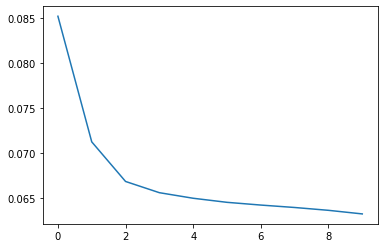

In [29]:
plt.plot(val_costs)

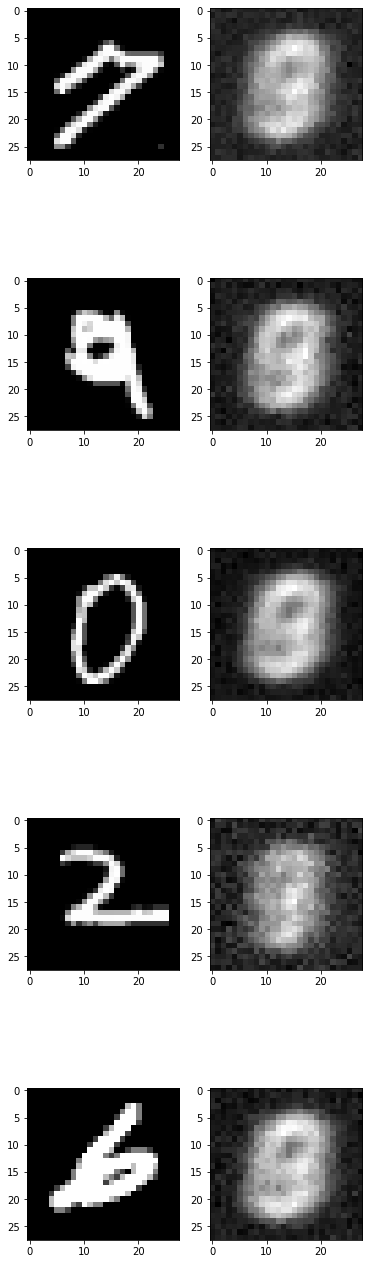

In [30]:
samples = X_train[0:100]
idx = 33


# use the convolutional autoencoder to make predictions on the
# testing images, then initialize our list of output images
denoised_samples_number = 5
noisy_samples = X_train[0:denoised_samples_number]
denoised_samples = forward_step(noisy_samples, layers)[-1]

fig, axs = plt.subplots(denoised_samples_number, 2, figsize=(6, 24))
axs_ = axs.ravel()

for i, (ns, ds) in enumerate(zip(noisy_samples, denoised_samples)):
  axs_[2*i].imshow(ns.reshape(28, 28), cmap="gray")
  axs_[2*i + 1].imshow(ds.reshape(28, 28), cmap="gray")

In [48]:
sample = X_train[20].reshape(1, -1)
noisy_sample = avgn_attack(sample, std=0.5, mean=0.5)
test = noisy_sample.reshape(-1, 1)
test.shape

(784, 1)

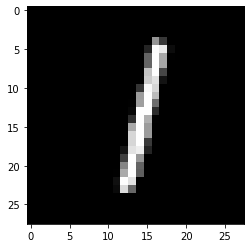

In [49]:
plt.imshow(sample.reshape(28, 28), "gray")

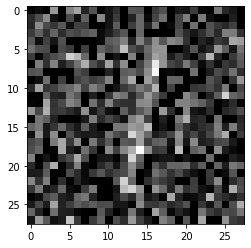

In [50]:
plt.imshow(noisy_sample.reshape(28, 28), "gray")

In [51]:
a = forward_step(sample, layers)

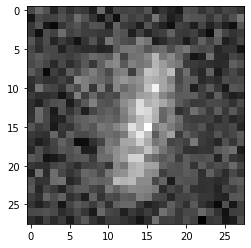

In [52]:
plt.imshow(a[-1].reshape(28, 28), "gray")

In [54]:
# sample

In [ ]:
a[-1]

In [ ]:
class test:
  def __init__(self):
    self.W = np.array([[1, 2], [3, 4], [5, 6]])
    self.b = np.array([11, 22])

  def get_params_iter(self):
      """Return an iterator over the parameters."""
      return itertools.chain(
          np.nditer(self.W, op_flags=['readwrite']),
          np.nditer(self.b, op_flags=['readwrite']))
    
  def get_params_grad(self):
    """Return a list of gradients over the parameters."""
    return [g for g in itertools.chain(
        np.nditer(self.W), np.nditer(self.b))]
  
  def ret_list(self):
    return self.W

In [ ]:
t = test()

In [ ]:
t.get_params_iter()

In [ ]:
# for i in t.get_params_grad():
#   print(i)
t.get_params_grad()


In [ ]:
a = t.ret_list()

In [ ]:
a[1] = 10101001